In [1]:
from google import colab

colab.drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
data_path = '/content/drive/Shareddrives/JobCare/Jobcare_data/'
submit_path = '/content/drive/Shareddrives/JobCare/submit/'
SEED = 42

In [3]:
import os
import sys
import platform
import random
import math
from typing import List ,Dict, Tuple

import pandas as pd
import numpy as np
 
import sklearn 
from sklearn.model_selection import StratifiedKFold , KFold
from sklearn.metrics import f1_score 

In [4]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 1.3 MB/s 


In [5]:
train_data = pd.read_csv(f'{data_path}train.csv')
test_data = pd.read_csv(f'{data_path}test.csv')

code_d = pd.read_csv(f'{data_path}속성_D_코드.csv')
code_h = pd.read_csv(f'{data_path}속성_H_코드.csv')
code_l = pd.read_csv(f'{data_path}속성_L_코드.csv')

train_data.shape , test_data.shape

((501951, 35), (46404, 34))

In [6]:
code_d.columns= ["attribute_d","attribute_d_d","attribute_d_s","attribute_d_m","attribute_d_l"]
code_h.columns= ["attribute_h","attribute_h_p","attribute_h_l"]
code_l.columns= ["attribute_l","attribute_l_d","attribute_l_s","attribute_l_m","attribute_l_l"]

In [7]:
#데이터 merge
def merge_codes(df:pd.DataFrame,df_code:pd.DataFrame,col:str)->pd.DataFrame:
    df = df.copy()
    df_code = df_code.copy()
    df_code = df_code.add_prefix(f"{col}_")
    df_code.columns.values[0] = col
    return pd.merge(df,df_code,how="left",on=col)

In [8]:
def preprocess_data(
                    df:pd.DataFrame,is_train:bool = True, cols_merge:List[Tuple[str,pd.DataFrame]] = []  , cols_equi:List[Tuple[str,str]]= [] ,
                    cols_drop:List[str] = ["id","person_prefer_f","person_prefer_g" ,"contents_open_dt"]
                    )->Tuple[pd.DataFrame,np.ndarray]:
    df = df.copy()

    y_data = None
    if is_train:
        y_data = df["target"].to_numpy()
        df = df.drop(columns="target")

    for col, df_code in cols_merge:
        df = merge_codes(df,df_code,col)

    cols = df.select_dtypes(bool).columns.tolist()
    df[cols] = df[cols].astype(int)

    for col1, col2 in cols_equi:
        df[f"{col1}_{col2}"] = (df[col1] == df[col2] ).astype(int)

    df = df.drop(columns=cols_drop)
    return (df , y_data)

In [9]:
# 소분류 중분류 대분류 속성코드 merge 컬럼명 및 데이터 프레임 리스트
cols_merge = [
              ("person_prefer_d_1" , code_d),
              ("person_prefer_d_2" , code_d),
              ("person_prefer_d_3" , code_d),
              ("contents_attribute_d" , code_d),
              ("person_prefer_h_1" , code_h),
              ("person_prefer_h_2" , code_h),
              ("person_prefer_h_3" , code_h),
              ("contents_attribute_h" , code_h),
              ("contents_attribute_l" , code_l),
]

# 회원 속성과 콘텐츠 속성의 동일한 코드 여부에 대한 컬럼명 리스트
cols_equi = [

    ("contents_attribute_c","person_prefer_c"),
    ("contents_attribute_e","person_prefer_e"),

    ("person_prefer_d_2_attribute_d_s" , "contents_attribute_d_attribute_d_s"),
    ("person_prefer_d_2_attribute_d_m" , "contents_attribute_d_attribute_d_m"),
    ("person_prefer_d_2_attribute_d_l" , "contents_attribute_d_attribute_d_l"),
    ("person_prefer_d_3_attribute_d_s" , "contents_attribute_d_attribute_d_s"),
    ("person_prefer_d_3_attribute_d_m" , "contents_attribute_d_attribute_d_m"),
    ("person_prefer_d_3_attribute_d_l" , "contents_attribute_d_attribute_d_l"),

    ("person_prefer_h_1_attribute_h_p" , "contents_attribute_h_attribute_h_p"),
    ("person_prefer_h_2_attribute_h_p" , "contents_attribute_h_attribute_h_p"),
    ("person_prefer_h_3_attribute_h_p" , "contents_attribute_h_attribute_h_p"),

]

# 학습에 필요없는 컬럼 리스트
cols_drop = ["id","person_prefer_f","person_prefer_g" ,"contents_open_dt", "contents_rn", ]

In [10]:
x_train, y_train = preprocess_data(train_data, cols_merge = cols_merge , cols_equi= cols_equi , cols_drop = cols_drop)
x_test, _ = preprocess_data(test_data,is_train = False, cols_merge = cols_merge , cols_equi= cols_equi  , cols_drop = cols_drop)
x_train.shape , y_train.shape , x_test.shape

((501951, 68), (501951,), (46404, 68))

In [25]:
# CatBoost 모델링
from catboost import Pool,CatBoostClassifier

def catboost_modeling(x_train, y_train, x_test, grow_policy, depth, learning_rate, l2_leaf_reg, random_seed, n):
  
  # 빈 Series인 test_pred 생성
  test_pred = pd.Series([0 for x in range(len(x_test))], index=x_test.index)
  
  # 10-fold 모델링을 n회 반복할 것
  for i in range(n):
    kf = KFold(n_splits=10,shuffle = True, random_state=random_seed+i)
    for train_index, valid_index in kf.split(x_train):
      train_X, train_y = x_train.iloc[train_index], y_train[train_index]
      valid_X, valid_y = x_train.iloc[valid_index], y_train[valid_index]
      
      # catBoost(grow_policy='Depthwise')
      model = CatBoostClassifier(eval_metric = 'AUC',              # AUC로 성능 측정
                                 iterations = 25000,               # 반복횟수 최대 25000
                                 metric_period = 25000,            # 중간결과 출력X
                                 early_stopping_rounds = 1000,     # 1000iteration 동안 AUC 증가 없으면 학습 중단
                                 task_type = 'GPU',                # GPU 사용
                                 grow_policy = grow_policy,        # 트리 노드 생성 방식
                                                                   # 1) Depthwise(지정한 depth에 이를 때까지 level 순으로 노드 분할)
                                                                   # 2) Lossguide(loss 변화가 큰 순으로 노드 분할)
                                 depth = depth,                    # 트리 깊이
                                 learning_rate = learning_rate,    # 러닝레이트
                                 l2_leaf_reg = l2_leaf_reg,        # L2 정규화
                                 random_seed = random_seed+i,      # 랜덤시드 고정
                                 )
      # 모델 학습
      model.fit(train_X, train_y, eval_set=(valid_X, valid_y))
    
      # 모델 적용
      test_pred += model.predict_proba(x_test)[:,1] /(10*n)
    
  # 설정된 디렉토리에 결과물 저장
  sample_submission = pd.read_csv(f'{data_path}sample_submission.csv', index_col = 0)
  submission = pd.DataFrame(data=test_pred, columns=sample_submission.columns, index=sample_submission.index)
  #sample_submission.to_csv(f"{submit_path}prediction.csv", index=False)
  submission.to_csv(f"{submit_path}CatBoost_{grow_policy}_{str(depth)}.csv", index=True)

  return test_pred

In [ ]:
data1 = catboost_modeling(x_train, y_train, x_test, 'Depthwise', 10, 0.02423, 20.35, 2014, 2)

0:	learn: 0.6496923	test: 0.6359651	best: 0.6359651 (0)	total: 106ms	remaining: 44m 13s
bestTest = 0.700838387
bestIteration = 6242
Shrink model to first 6243 iterations.
0:	learn: 0.6500806	test: 0.6317837	best: 0.6317837 (0)	total: 105ms	remaining: 43m 46s
bestTest = 0.7029445171
bestIteration = 4155
Shrink model to first 4156 iterations.
0:	learn: 0.6486618	test: 0.6311721	best: 0.6311721 (0)	total: 107ms	remaining: 44m 23s
bestTest = 0.7010304332
bestIteration = 4430
Shrink model to first 4431 iterations.
0:	learn: 0.6493526	test: 0.6320873	best: 0.6320873 (0)	total: 108ms	remaining: 44m 56s
bestTest = 0.7005336881
bestIteration = 4066
Shrink model to first 4067 iterations.
0:	learn: 0.6493253	test: 0.6373797	best: 0.6373797 (0)	total: 105ms	remaining: 43m 56s
bestTest = 0.7026543617
bestIteration = 4533
Shrink model to first 4534 iterations.
0:	learn: 0.6488696	test: 0.6368369	best: 0.6368369 (0)	total: 115ms	remaining: 47m 55s
bestTest = 0.7052407265
bestIteration = 4300
Shrink m

In [ ]:
datas = pd.read_csv("/content/drive/Shareddrives/JobCare/submit/CatBoost_Depthwise_10.csv")
data_fin = pd.DataFrame(datas*2)
data_fin.columns = datas.columns
data_fin

In [ ]:
data4 = catboost_modeling(x_train, y_train, x_test, 'Lossguide', 16, 0.01213, 5.027, 2022, 2)

In [ ]:
# 최종 모델 앙상블
sample_submission = pd.read_csv(f'{data_path}sample_submission.csv')
data_final = pd.DataFrame(data1)
data_final.columns = sample_submission.columns
data_final.to_csv(f"{submit_path}final_data1_only.csv", index=True)
data_final

NameError: ignored

In [ ]:
'''# 최종 모델 앙상블
sample_submission = pd.read_csv(f'{data_path}sample_submission.csv')
data_final = pd.DataFrame((data1+data2)/2 *1/3 + (data3+data4)/2 *2/3)
data_final.columns = sample_submission.columns
data_final.to_csv('data_final.csv', index =True)
data_final'''

In [ ]:
y_pred=clf.predict(x_test)

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

ValueError: ignored

## sklearn 홈페이지 참조

In [ ]:
import pandas as pd 

jobs = pd.read_csv('/content/drive/Shareddrives/JobCare/Jobcare_data/train.csv', sep=',')

In [ ]:
print(jobs.columns)
print(jobs.id[0:5])

Index(['id', 'd_l_match_yn', 'd_m_match_yn', 'd_s_match_yn', 'h_l_match_yn',
       'h_m_match_yn', 'h_s_match_yn', 'person_attribute_a',
       'person_attribute_a_1', 'person_attribute_b', 'person_prefer_c',
       'person_prefer_d_1', 'person_prefer_d_2', 'person_prefer_d_3',
       'person_prefer_e', 'person_prefer_f', 'person_prefer_g',
       'person_prefer_h_1', 'person_prefer_h_2', 'person_prefer_h_3',
       'contents_attribute_i', 'contents_attribute_a',
       'contents_attribute_j_1', 'contents_attribute_j',
       'contents_attribute_c', 'contents_attribute_k', 'contents_attribute_l',
       'contents_attribute_d', 'contents_attribute_m', 'contents_attribute_e',
       'contents_attribute_h', 'person_rn', 'contents_rn', 'contents_open_dt',
       'target'],
      dtype='object')
0    0
1    1
2    2
3    3
4    4
Name: id, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

X=jobs[['d_l_match_yn', 'd_m_match_yn', 'd_s_match_yn', 'h_l_match_yn',
       'h_m_match_yn', 'h_s_match_yn', 'person_attribute_a',
       'person_attribute_a_1', 'person_attribute_b', 'person_prefer_c',
       'person_prefer_d_1', 'person_prefer_d_2', 'person_prefer_d_3',
       'person_prefer_e', 'person_prefer_f', 'person_prefer_g',
       'person_prefer_h_1', 'person_prefer_h_2', 'person_prefer_h_3',
       'contents_attribute_i', 'contents_attribute_a',
       'contents_attribute_j_1', 'contents_attribute_j',
       'contents_attribute_c', 'contents_attribute_k', 'contents_attribute_l',
       'contents_attribute_d', 'contents_attribute_m', 'contents_attribute_e',
       'contents_attribute_h', 'person_rn', 'contents_rn']]  # Features ('id','contents_open_dt' 제외)
y=jobs['target']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6173548669863068


In [ ]:
import pandas as pd
jobs.newcol = []
for i in range(len(jobs.columns)):
  if i != 0 and i <= 32:
    jobs.newcol.append(jobs.columns[i])
feature_imp = pd.Series(clf.feature_importances_,index=jobs.newcol).sort_values(ascending=False)
feature_imp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


contents_rn               0.083424
person_rn                 0.081912
contents_attribute_l      0.080965
contents_attribute_d      0.070320
person_prefer_d_2         0.063553
person_prefer_d_1         0.059742
contents_attribute_h      0.058717
person_prefer_d_3         0.057571
person_prefer_h_2         0.053023
person_prefer_h_3         0.049226
person_prefer_h_1         0.047152
person_attribute_a_1      0.038158
person_prefer_e           0.033528
contents_attribute_e      0.029345
person_attribute_b        0.024194
contents_attribute_m      0.024036
person_prefer_c           0.018411
contents_attribute_j_1    0.018193
contents_attribute_i      0.017814
contents_attribute_a      0.017351
d_l_match_yn              0.012203
contents_attribute_c      0.011137
person_attribute_a        0.010326
d_m_match_yn              0.007126
h_m_match_yn              0.006368
h_s_match_yn              0.006176
h_l_match_yn              0.005975
contents_attribute_j      0.005190
d_s_match_yn        

In [ ]:
print(feature_imp.index[:16])

Index(['contents_rn', 'person_rn', 'contents_attribute_l',
       'contents_attribute_d', 'person_prefer_d_2', 'person_prefer_d_1',
       'contents_attribute_h', 'person_prefer_d_3', 'person_prefer_h_2',
       'person_prefer_h_3', 'person_prefer_h_1', 'person_attribute_a_1',
       'person_prefer_e', 'contents_attribute_e', 'person_attribute_b',
       'contents_attribute_m'],
      dtype='object')


No handles with labels found to put in legend.


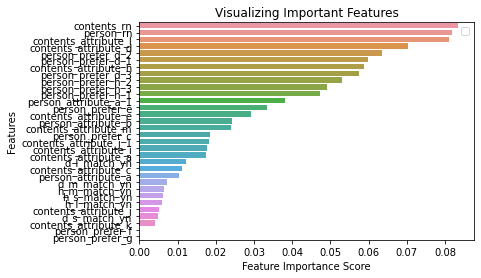

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

그래서 위 요소들 중에 가장 importance 가 낮은것 제외 상위 16개만 학습하면?

In [ ]:
from sklearn.model_selection import train_test_split
# Split dataset into features and labels
X=jobs[['contents_rn', 'person_rn', 'contents_attribute_l',
       'contents_attribute_d', 'person_prefer_d_2', 'person_prefer_d_1',
       'contents_attribute_h', 'person_prefer_d_3', 'person_prefer_h_2',
       'person_prefer_h_3', 'person_prefer_h_1', 'person_attribute_a_1',
       'person_prefer_e', 'contents_attribute_e', 'person_attribute_b',
       'contents_attribute_m']]  # Removed feature "sepal length"
y=jobs['target']                                       
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=5) 



In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

# prediction on test set
y_pred=clf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6007752599853144
